## Predicting Parole Violators ##

In many societies, inmates who are likely no longer a threat to society are released from prison on "parole." The parole system allows the prisoner to complete the remainder of his/her sentence outside of prison and requires the parolee to obide by certain terms and conditions. Should a former inmate violate the terms of his/her parole, they may be returned to prison. 

Parole boards are identify those inmates who are good candidates for release on parole. "Good candidates" are inmates who are unlikely to commit additional crimes once released and will abide by the terms of his/her parole.

(source: MITx)

### The Problem ###

Here, we build and validate a model that predicts whether or not an inmate will violate the terms of his/her parole to assit parole boards in detetermining whom to release on parole.

(source: MITx)

### The Data ###

We will use data from the United States 2004 National Corrections Reporting Program -- a nationwide census of parole releases. The scope of our analysis is limited to parolees who served 1) no more than 6 months in prison and 2) whose maximum sentence for all charges was less than 18 months. The dataset contains information both on parolees who completed their parole in 2004 and those who violated the terms of their parole in the same year.

Our dataset contains the following predictors: 

**male**: 1 if the parolee is male, 0 if female

**race**: 1 if the parolee is white, 2 otherwise

**age**: the parolee's age (in years) when he or she was released from prison

**state**: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.

**time.served**: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).

**max.sentence**: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).

**multiple.offenses**: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.

**crime**: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.

**violator**: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.

(source: MITx)

In [2]:
parole = read.csv("parole.csv")

In [3]:
str(parole)

'data.frame':	675 obs. of  9 variables:
 $ male             : int  1 0 1 1 1 1 1 0 0 1 ...
 $ race             : int  1 1 2 1 2 2 1 1 1 2 ...
 $ age              : num  33.2 39.7 29.5 22.4 21.6 46.7 31 24.6 32.6 29.1 ...
 $ state            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ time.served      : num  5.5 5.4 5.6 5.7 5.4 6 6 4.8 4.5 4.7 ...
 $ max.sentence     : int  18 12 12 18 12 18 18 12 13 12 ...
 $ multiple.offenses: int  0 0 0 0 0 0 0 0 0 0 ...
 $ crime            : int  4 3 3 1 1 4 3 1 3 2 ...
 $ violator         : int  0 0 0 0 0 0 0 0 0 0 ...


In [4]:
summary(parole)

      male             race            age            state      
 Min.   :0.0000   Min.   :1.000   Min.   :18.40   Min.   :1.000  
 1st Qu.:1.0000   1st Qu.:1.000   1st Qu.:25.35   1st Qu.:2.000  
 Median :1.0000   Median :1.000   Median :33.70   Median :3.000  
 Mean   :0.8074   Mean   :1.424   Mean   :34.51   Mean   :2.887  
 3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:42.55   3rd Qu.:4.000  
 Max.   :1.0000   Max.   :2.000   Max.   :67.00   Max.   :4.000  
  time.served     max.sentence   multiple.offenses     crime      
 Min.   :0.000   Min.   : 1.00   Min.   :0.0000    Min.   :1.000  
 1st Qu.:3.250   1st Qu.:12.00   1st Qu.:0.0000    1st Qu.:1.000  
 Median :4.400   Median :12.00   Median :1.0000    Median :2.000  
 Mean   :4.198   Mean   :13.06   Mean   :0.5363    Mean   :2.059  
 3rd Qu.:5.200   3rd Qu.:15.00   3rd Qu.:1.0000    3rd Qu.:3.000  
 Max.   :6.000   Max.   :18.00   Max.   :1.0000    Max.   :4.000  
    violator     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000

### Exploratory Data Analysis ###

In [8]:
install.packages("ggplot2")
library(ggplot2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [17]:
install.packages("corrplot")
library(corrplot)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
corrplot 0.84 loaded


The correlation matrix below suggests multicollinearity will not be a problem as we move towards modelling. The variables seem to have little to do with one another and, in all cases, fall below the .70 threshold we use for potential variable elimination. 

Many of our predictors, in addition to our response variable, are categorical. So, we believe it would be fruitful to continue looking at the data, albeit through a different lens.

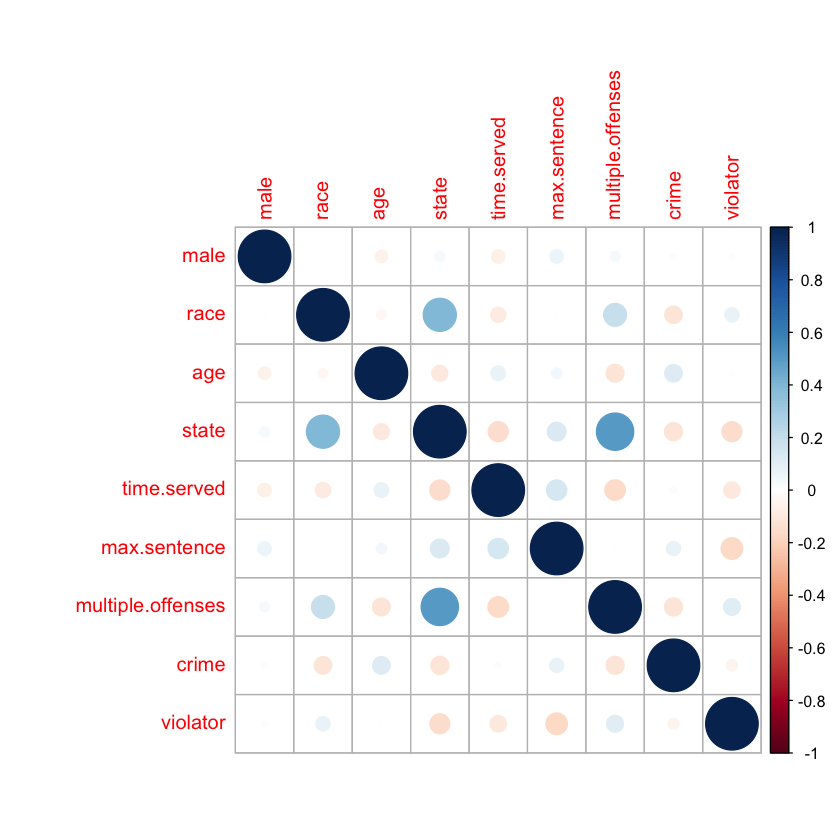

In [22]:
corrplot(cor(parole, use="complete.obs"))

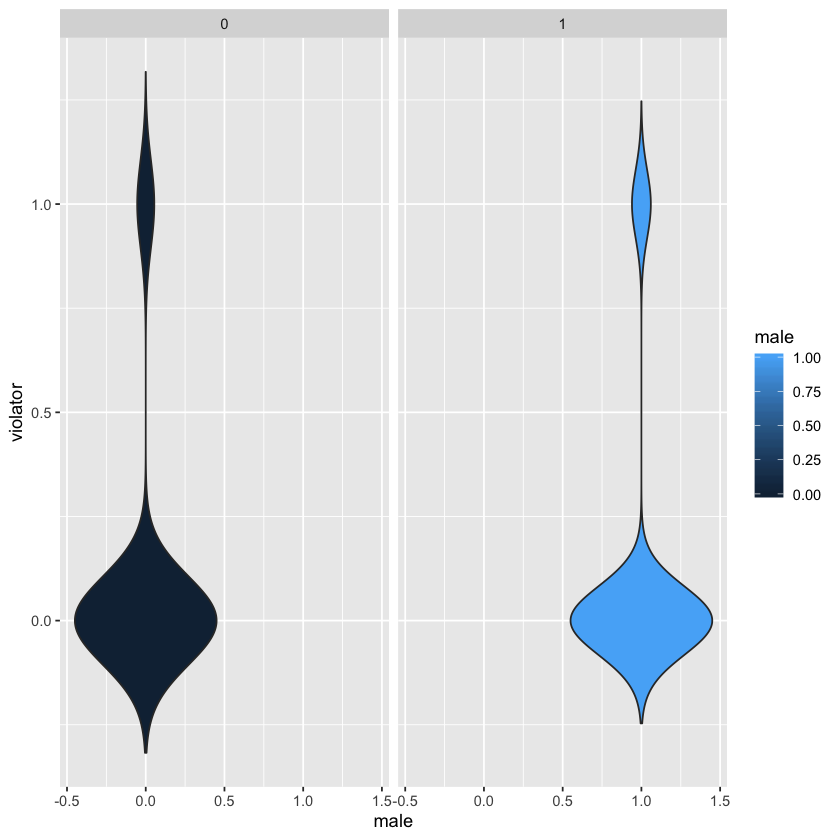

In [64]:
v_sex = ggplot(parole, aes(x=male, y=violator, fill=male, group=1))
v_sex + geom_violin(trim=FALSE) + facet_wrap(~ male)

In [40]:
table(parole$violator, parole$male)

   
      0   1
  0 116 481
  1  14  64

In [55]:
which(is.na(parole$male))

integer(0)